# Imports & Configs

In [18]:
%pip install numpy pandas seaborn matplotlib optuna sklearn xgboost catboost lightgbm > /dev/null 2>&1

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
import joblib
from xgboost import XGBClassifier
from tabulate import tabulate
import os
import google.generativeai as genai

API_KEY=""
genai.configure(api_key=API_KEY)

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Preprocessing & EDA

In [ ]:
train=pd.read_csv('Train_data.csv')
test=pd.read_csv('Test_data.csv')
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [22]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [23]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
train.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


## Missing Data

In [25]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

No missing values

## Duplicates 

In [26]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


Great! No duplicates

## Outliers 

In [27]:
# for col in df:
#     if col != 'class' and is_numeric_dtype(df[col]):
#         fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#         g1 = sns.boxplot(x = df[col], ax=ax[0])
#         g2 = sns.scatterplot(data=df, x=df[col],y=df['class'], ax=ax[1])
#         plt.show()

No outliers

<AxesSubplot:>

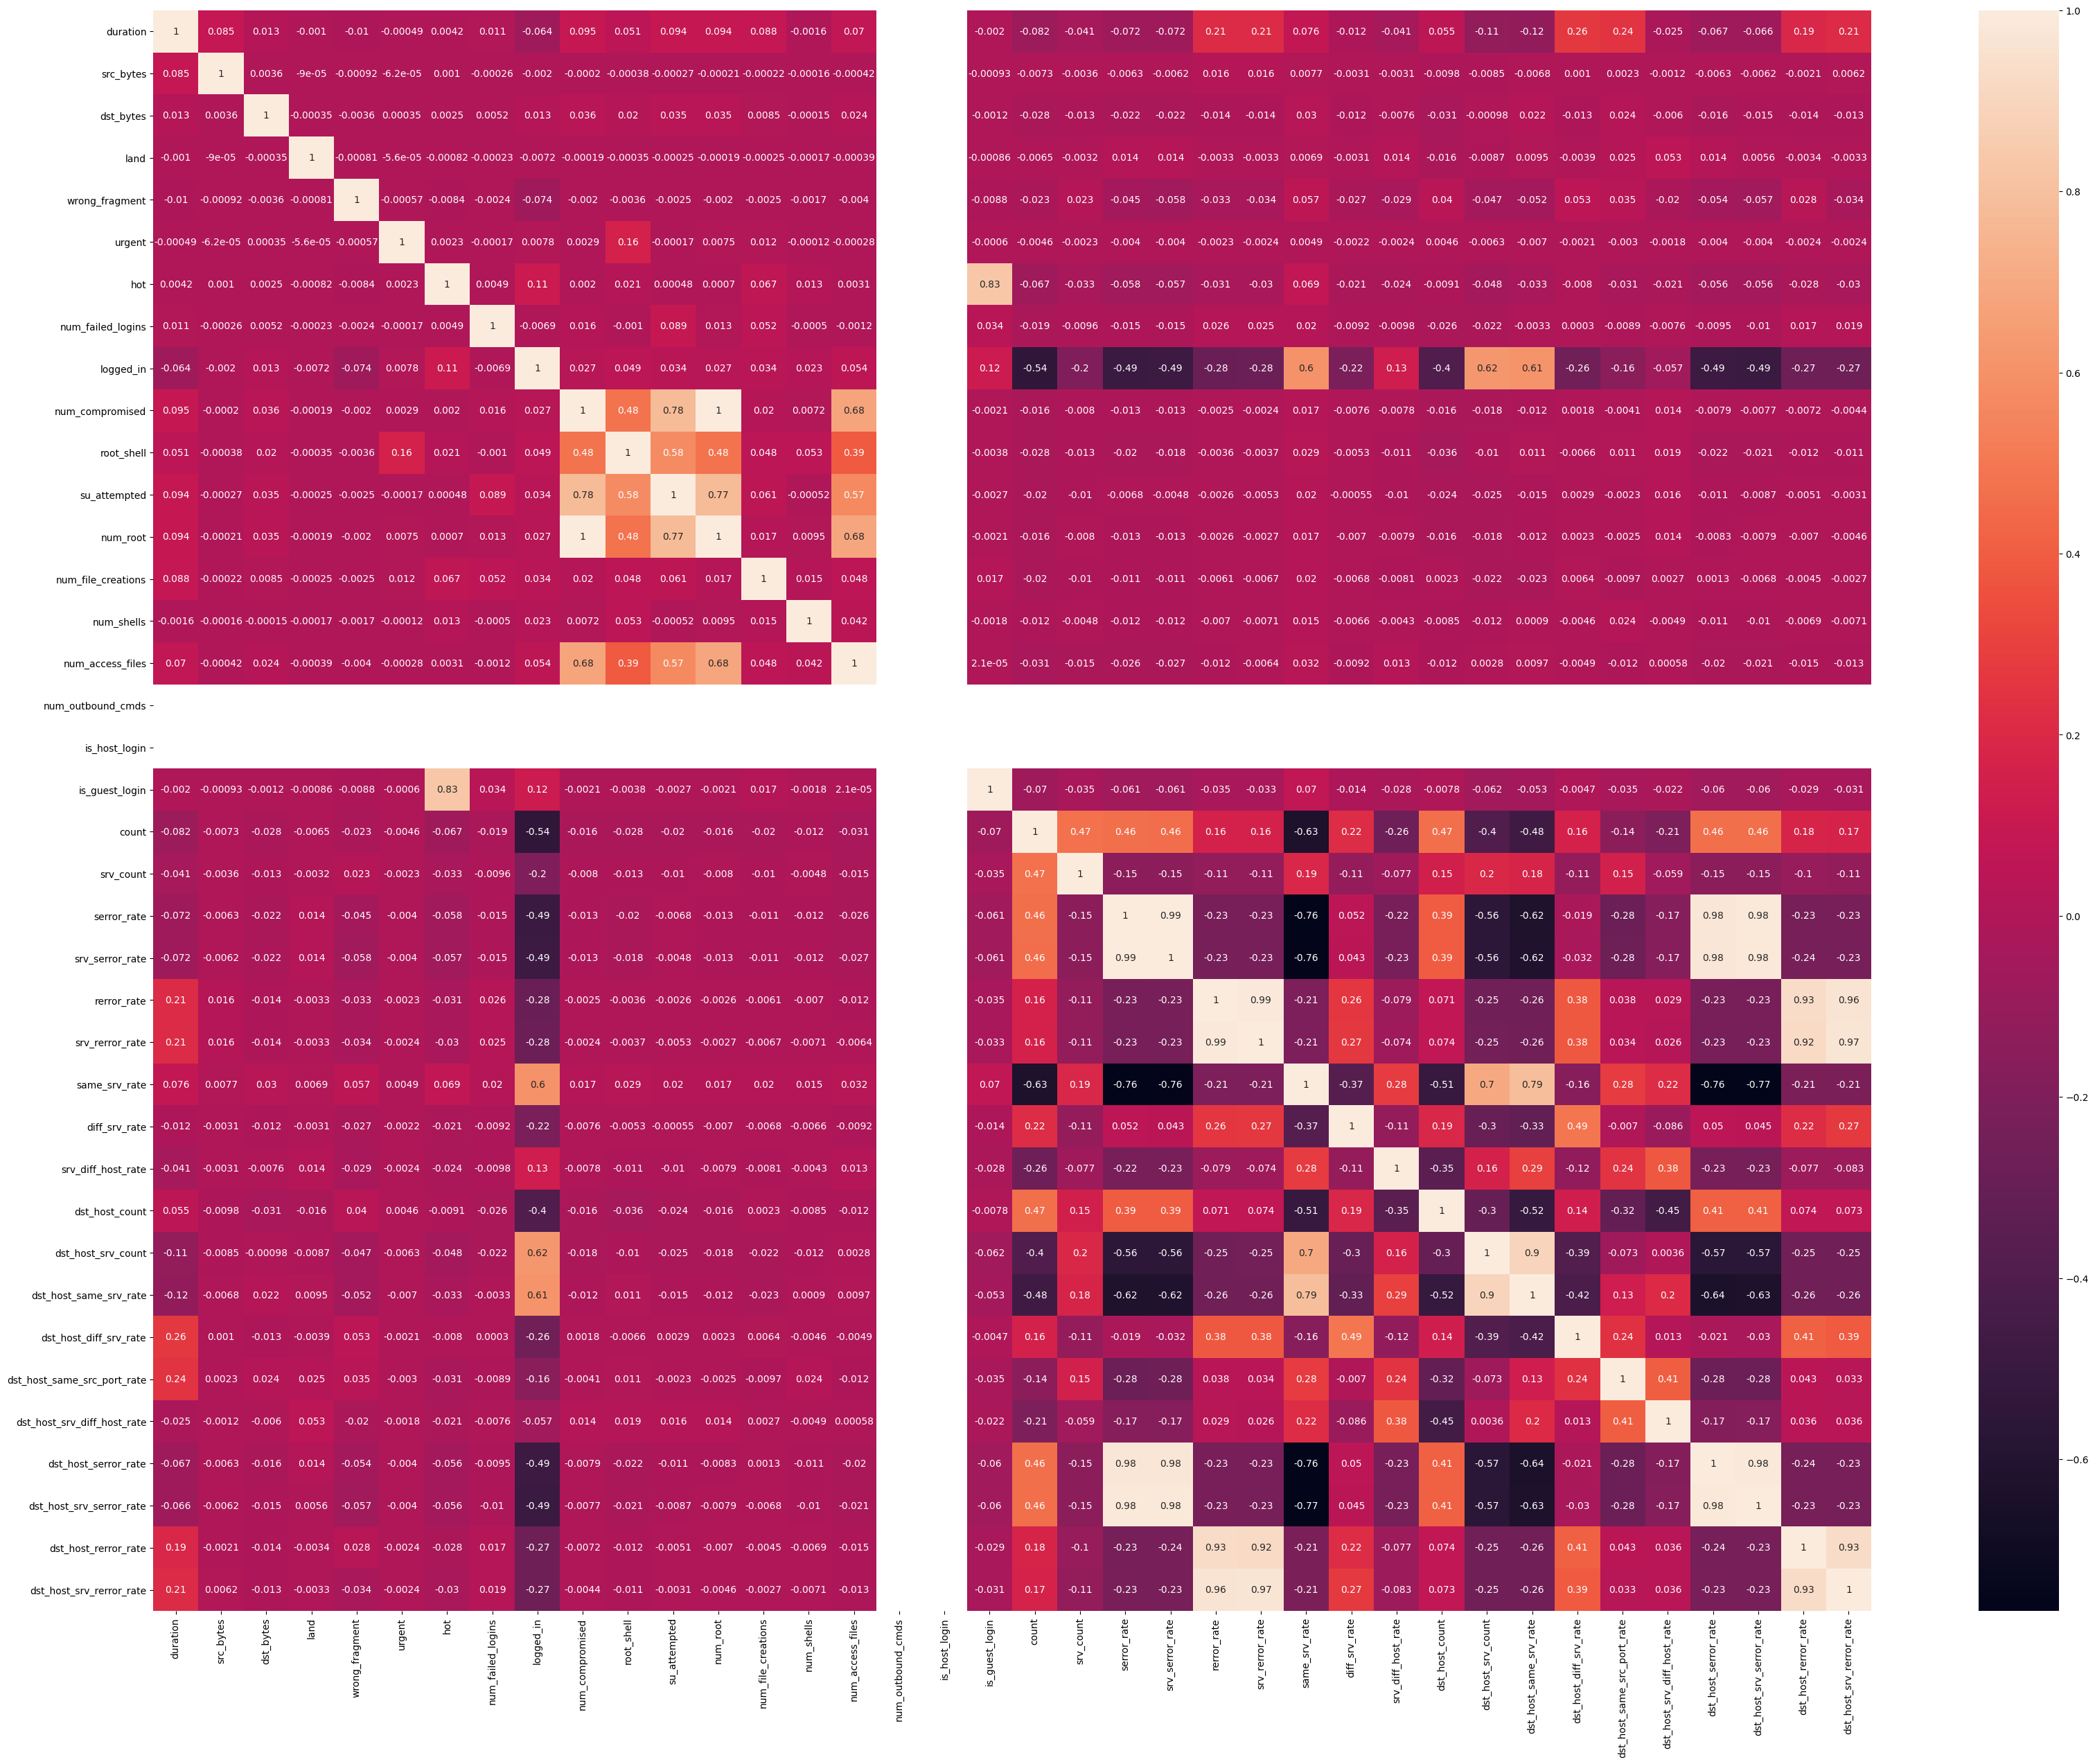

In [28]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)


<AxesSubplot:xlabel='class', ylabel='count'>

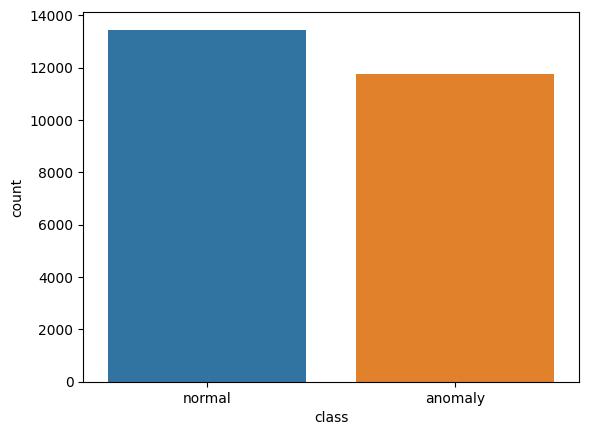

In [29]:
sns.countplot(x=train['class'])

# Label Encoding

In [30]:
encoding_dict = {"protocol_type":LabelEncoder(), 
                 "service":LabelEncoder(), 
                 "flag":LabelEncoder()}
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [31]:
joblib.dump(encoding_dict, 'encoders.joblib')

['encoders.joblib']

In [32]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


# Feature selection

In [33]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [34]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate']

In [35]:
X_train = X_train[selected_features]

# Split and scale data

In [36]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

# K Nearest Neighbors (KNN) classification model

In [38]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [39]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9814765811061127], datetime_start=datetime.datetime(2024, 11, 12, 20, 5, 3, 362066), datetime_complete=datetime.datetime(2024, 11, 12, 20, 5, 4, 38692), params={'KNN_n_neighbors': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [40]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9851990472949983
Test Score: 0.9814765811061127


# Logistic Regression Model

In [41]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [42]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.9418169445389588
Test Score: 0.938872717650172


# Decision Tree Classifier

In [43]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [44]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.9949722148716592], datetime_start=datetime.datetime(2024, 11, 12, 20, 5, 6, 579917), datetime_complete=datetime.datetime(2024, 11, 12, 20, 5, 6, 606497), params={'dt_max_depth': 12, 'dt_max_features': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=5, value=None)


In [45]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.9994329136894635
Test Score: 0.9936491135220958


In [46]:
joblib.dump(dt,"decision_tree.pkl")

['decision_tree.pkl']

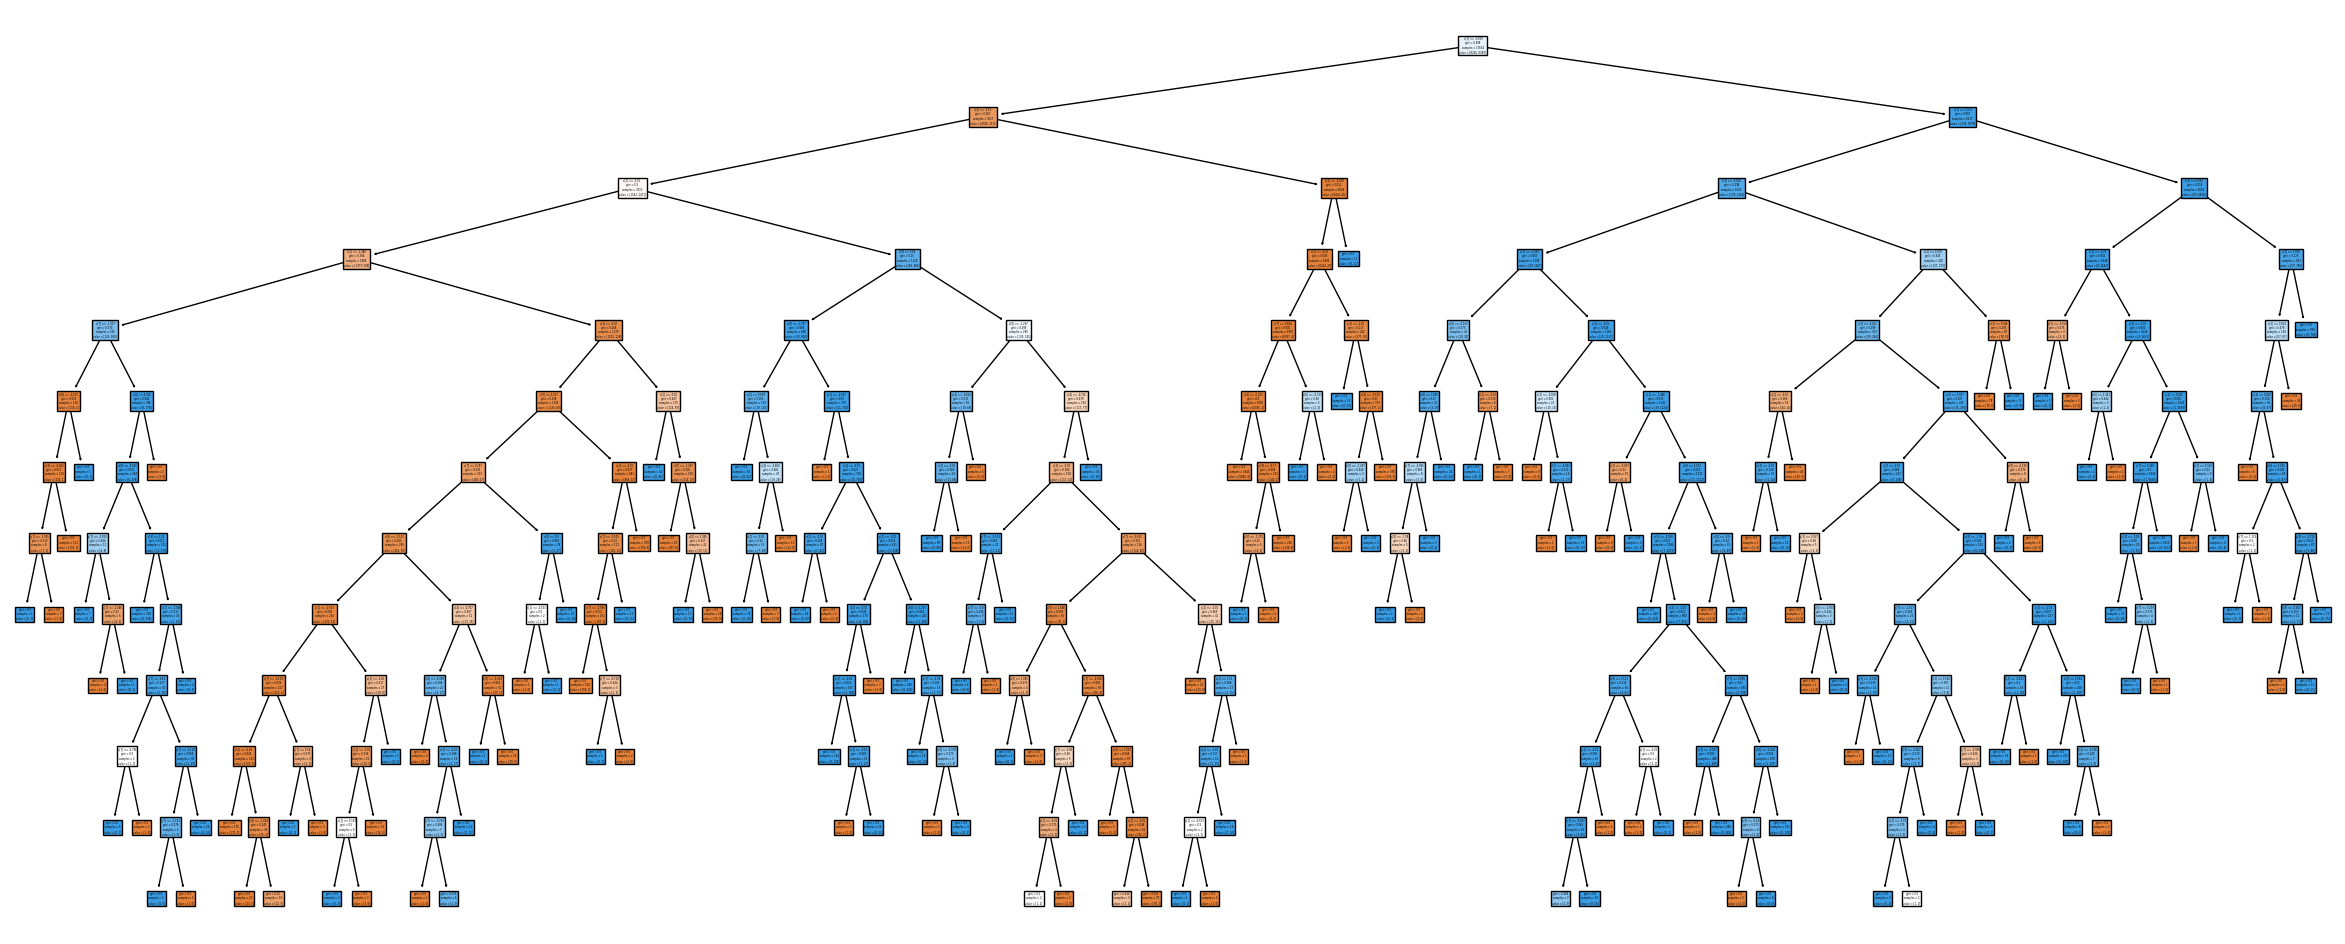

In [47]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

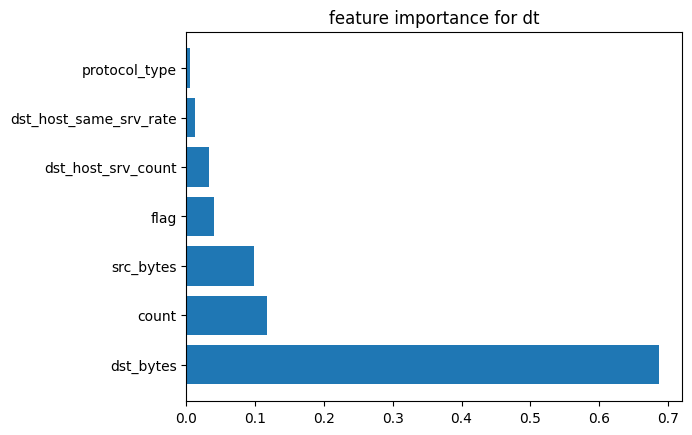

In [48]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

features_names = selected_features

f_importance(abs(dt.feature_importances_), features_names, top=7)

# Random Forest Classifier

In [49]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [50]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)

FrozenTrial(number=17, state=TrialState.COMPLETE, values=[0.9957660756813972], datetime_start=datetime.datetime(2024, 11, 12, 20, 5, 21, 216454), datetime_complete=datetime.datetime(2024, 11, 12, 20, 5, 21, 664419), params={'rf_max_depth': 32, 'rf_max_features': 7, 'rf_n_estimators': 20}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=17, value=None)


In [51]:
rf = RandomForestClassifier(max_features = study_rf.best_trial.params['rf_max_features'], max_depth = study_rf.best_trial.params['rf_max_depth'], n_estimators = study_rf.best_trial.params['rf_n_estimators'])
rf.fit(x_train, y_train)

rf_train, rf_test = rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")

Train Score: 1.0
Test Score: 0.9952368351415718


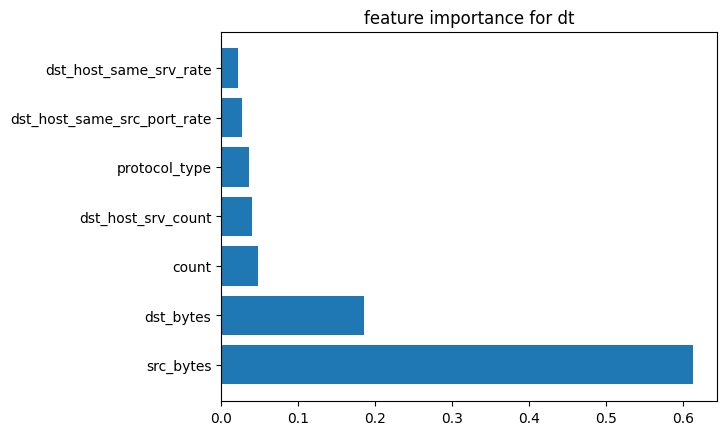

In [52]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

features_names = selected_features

f_importance(abs(rf.feature_importances_), features_names, top=7)

# SKLearn Gradient Boosting Model

In [53]:
SKGB = GradientBoostingClassifier(random_state=42)
SKGB.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

In [54]:
SKGB_train, SKGB_test = SKGB.score(x_train , y_train), SKGB.score(x_test , y_test)

print(f"Training Score: {SKGB_train}")
print(f"Test Score: {SKGB_test}")

Training Score: 0.9952364749914937
Test Score: 0.9920613919026198


# XGBoost Gradient Boosting Model

In [55]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [56]:
xgb_train, xgb_test = xgb_model.score(x_train , y_train), xgb_model.score(x_test , y_test)

print(f"Training Score: {xgb_train}")
print(f"Test Score: {xgb_test}")

Training Score: 0.9999432913689463
Test Score: 0.9955014554114845


# Light Gradient Boosting Model

In [57]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


LGBMClassifier(random_state=42)

In [58]:
lgb_train, lgb_test = lgb_model.score(x_train , y_train), lgb_model.score(x_test , y_test)

print(f"Training Score: {lgb_train}")
print(f"Test Score: {lgb_test}")

Training Score: 0.9999432913689463
Test Score: 0.9956337655464409


# SKLearn AdaBoost Model

In [59]:
ab_model = AdaBoostClassifier(random_state=42)

In [60]:
ab_model.fit(x_train, y_train)

AdaBoostClassifier(random_state=42)

In [61]:
ab_train, ab_test = ab_model.score(x_train , y_train), ab_model.score(x_test , y_test)

print(f"Training Score: {ab_train}")
print(f"Test Score: {ab_test}")

Training Score: 0.981399569014404
Test Score: 0.9817412013760254


# CatBoost Classifier Model

In [62]:
cb_model = CatBoostClassifier(verbose=0)

In [63]:
cb_model.fit(x_train, y_train)

In [64]:
cb_train, cb_test = cb_model.score(x_train , y_train), cb_model.score(x_test , y_test)

print(f"Training Score: {cb_train}")
print(f"Test Score: {cb_test}")

Training Score: 0.9984688669615516
Test Score: 0.9940460439269648


# Naive Baye Model

In [65]:
BNB_model = BernoulliNB()
BNB_model.fit(x_train, y_train)

BernoulliNB()

In [66]:
BNB_train, BNB_test = BNB_model.score(x_train , y_train), BNB_model.score(x_test , y_test)

print(f"Training Score: {BNB_train}")
print(f"Test Score: {BNB_test}")

Training Score: 0.8937847340365204
Test Score: 0.8948134427097115


# Voting Model 

In [67]:
v_clf = VotingClassifier(estimators=[('KNeighborsClassifier', KNN_model), ("XGBClassifier", xgb_model), ("RandomForestClassifier", rf), ("DecisionTree", dt), ("XGBoost", xgb_model), ("LightGB", lgb_model), ("AdaBoost", ab_model), ("Catboost", cb_model)], voting = "hard")

In [68]:
v_clf.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=6)),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_po...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('LightGB', LGBMClassifier(random_state=42)),
                             ('AdaBoost', AdaBoostClassifier(random_state=42)),
                             ('Catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000021EAD8FA470>)])

In [69]:
voting_train, voting_test = v_clf.score(x_train , y_train), v_clf.score(x_test , y_test)

print(f"Training Score: {voting_train}")
print(f"Test Score: {voting_test}")

Training Score: 0.9998865827378927
Test Score: 0.9955014554114845


# SVM Model

In [70]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'linearSVC'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(x_train, y_train)
    elif kernel == 'linearSVC':
        classifier_obj = LinearSVC(C=c).fit(x_train, y_train)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(x_train, y_train)
        
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [71]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=1)
print(study_svm.best_trial)

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9415189203492987], datetime_start=datetime.datetime(2024, 11, 12, 20, 6, 17, 361110), datetime_complete=datetime.datetime(2024, 11, 12, 20, 6, 17, 787906), params={'kernel': 'linearSVC', 'c': 0.04}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly', 'linearSVC')), 'c': FloatDistribution(high=1.0, log=False, low=0.02, step=0.02)}, trial_id=0, value=None)


In [72]:
if study_svm.best_trial.params['kernel'] in ['linear', 'rbf']:
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'])
elif study_svm.best_trial.params['kernel'] == 'linearSVC':
    SVM_model = LinearSVC(C=study_svm.best_trial.params['c'])
elif study_svm.best_trial.params['kernel'] == 'poly':
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'], degree=study_svm.best_trial.params['degree'])

SVM_model.fit(x_train, y_train)


LinearSVC(C=0.04)

In [73]:
SVM_train, SVM_test = SVM_model.score(x_train , y_train), SVM_model.score(x_test , y_test)

print(f"Training Score: {SVM_train}")
print(f"Test Score: {SVM_test}")

Training Score: 0.944992627877963
Test Score: 0.9415189203492987


# Deep Learning (ANN) Model

In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import optuna

data = pd.read_csv('Train_data.csv')

label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

X = data.drop('class', axis=1)
y = data['class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def create_ann_model(input_dim, units1=64, units2=32, dropout1=0.5, dropout2=0.5):
    model = Sequential()
    model.add(Dense(units=units1, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout1))
    model.add(Dense(units=units2, activation='relu'))
    model.add(Dropout(dropout2))
    model.add(Dense(units=1, activation='sigmoid'))  # Use 'softmax' if you have multiple classes
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(units1, units2, dropout1, dropout2):
    model = create_ann_model(x_train.shape[1], units1, units2, dropout1, dropout2)
    
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return test_accuracy

def objective(trial):
    units1 = trial.suggest_int('units1', 32, 128)
    units2 = trial.suggest_int('units2', 16, 64)
    dropout1 = trial.suggest_float('dropout1', 0.2, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.2, 0.5)
    
    return train_and_evaluate_model(units1, units2, dropout1, dropout2)

study_ann = optuna.create_study(direction='maximize')
study_ann.optimize(objective, n_trials=10)

print('Best trial:')
trial = study_ann.best_trial
print(f'  Accuracy: {trial.value}')
print(f'  Params: {trial.params}')

best_params = trial.params
final_model = create_ann_model(x_train.shape[1], **best_params)
history = final_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

train_loss, train_accuracy = final_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=0)

print(f"Final Train Accuracy: {train_accuracy}")
print(f"Final Test Accuracy: {test_accuracy}")

y_pred_train = final_model.predict(x_train)
y_pred_test = final_model.predict(x_test)

y_pred_train_labels = (y_pred_train > 0.5).astype(int)
y_pred_test_labels = (y_pred_test > 0.5).astype(int)

ann_train_accuracy = accuracy_score(y_train, y_pred_train_labels)
ann_test_accuracy = accuracy_score(y_test, y_pred_test_labels)

print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train_labels)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test_labels)}")

Best trial:
  Accuracy: 0.990672767162323
  Params: {'units1': 74, 'units2': 50, 'dropout1': 0.298329358930165, 'dropout2': 0.2578019794919268}
Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9159 - loss: 0.2283 - val_accuracy: 0.9673 - val_loss: 0.0799
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9698 - loss: 0.0948 - val_accuracy: 0.9735 - val_loss: 0.0648
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9778 - loss: 0.0643 - val_accuracy: 0.9819 - val_loss: 0.0508
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9839 - loss: 0.0489 - val_accuracy: 0.9819 - val_loss: 0.0491
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9859 - loss: 0.0417 - val_accuracy: 0.9836 - val_loss: 0.0443
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9879 - loss: 0.0361 - val_accuracy: 0.9826 - val_loss: 0.0489
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9888 - loss: 0.0360 - 

# Genetic Algorithm with KNN

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from joblib import Parallel, delayed  
import random
import itertools

train = pd.read_csv('C:/Users/ishan/OneDrive/Desktop/proj_component/Train_data.csv')
test = pd.read_csv('C:/Users/ishan/OneDrive/Desktop/proj_component/Test_data.csv')

X_train = train.drop(['class'], axis=1)
Y_train = train['class']

categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)

rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=10)
rfe.fit(X_train_transformed, Y_train)

selected_feature_indices = np.where(rfe.support_)[0]

X_train = X_train_transformed[:, selected_feature_indices]

X_test = preprocessor.transform(test)  
X_test = X_test[:, selected_feature_indices]  

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

def fitness_function(k):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, x_train, y_train, cv=5, scoring='accuracy') 
    return np.mean(scores)  

def genetic_algorithm(population_size=10, generations=20, mutation_rate=0.1, n_jobs=-1):
    
    population = [random.randint(1, 20) for _ in range(population_size)]  
    best_k = None
    best_accuracy = 0

    for generation in range(generations):
        fitness_scores = Parallel(n_jobs=n_jobs)(delayed(fitness_function)(k) for k in population)

        max_index = np.argmax(fitness_scores)
        if fitness_scores[max_index] > best_accuracy:
            best_accuracy = fitness_scores[max_index]
            best_k = population[max_index]

        next_generation = []
        
        for _ in range(population_size):
            parents = np.random.choice(population, size=2, p=np.array(fitness_scores) / sum(fitness_scores))
            child = int(np.mean(parents))
            
            if random.random() < mutation_rate:
                child += random.choice([-1, 1])  
            
            child = max(1, min(20, child))
            next_generation.append(child)

        population = next_generation

    return best_k, best_accuracy

optimal_k, optimal_accuracy = genetic_algorithm(n_jobs=-1)  

knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(x_train, y_train)

train_predictions = knn_model.predict(x_train)
gkn_train_accuracy = accuracy_score(y_train, train_predictions)

test_predictions = knn_model.predict(x_test)
gkn_test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Optimal K: {optimal_k}")
print(f"Train Accuracy: {gkn_train_accuracy}")
print(f"Test Accuracy: {gkn_test_accuracy}")


Optimal K: 3
Train Accuracy: 0.9875241011681978
Test Accuracy: 0.9786980682720297


# Genetic Algorithm with Logistic Regression

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from joblib import Parallel, delayed  
import random

train = pd.read_csv('C:/Users/ishan/OneDrive/Desktop/Proj_demonstration/Train_data.csv')
test = pd.read_csv('C:/Users/ishan/OneDrive/Desktop/Proj_demonstration/Test_data.csv')

X_train = train.drop(['class'], axis=1)
Y_train = train['class']

categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)

rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=10)
rfe.fit(X_train_transformed, Y_train)

selected_feature_indices = np.where(rfe.support_)[0]

X_train = X_train_transformed[:, selected_feature_indices]

X_test = preprocessor.transform(test)
X_test = X_test[:, selected_feature_indices]  

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

def fitness_function_logreg(params):
    C, penalty, solver = params
    logreg_model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000)
    scores = cross_val_score(logreg_model, x_train, y_train, cv=5, scoring='accuracy')
    return np.mean(scores)

def genetic_algorithm_logreg(population_size=10, generations=20, mutation_rate=0.1, n_jobs=-1):
    
    penalty_options = ['l2']  
    solver_options = ['lbfgs', 'saga']  
    population = [(random.uniform(0.01, 10), random.choice(penalty_options), random.choice(solver_options))
                  for _ in range(population_size)]
    best_params = None
    best_accuracy = 0

    for generation in range(generations):
        fitness_scores = Parallel(n_jobs=n_jobs)(delayed(fitness_function_logreg)(params) for params in population)

        max_index = np.argmax(fitness_scores)
        if fitness_scores[max_index] > best_accuracy:
            best_accuracy = fitness_scores[max_index]
            best_params = population[max_index]

        next_generation = []
        
        for _ in range(population_size):
            parents = random.sample(population, 2)
            child_C = np.mean([parents[0][0], parents[1][0]])

            child_penalty = random.choice([parents[0][1], parents[1][1]])
            child_solver = random.choice([parents[0][2], parents[1][2]])

            child = (child_C, child_penalty, child_solver)
            
            if random.random() < mutation_rate:
                child = (child[0] + random.uniform(-0.5, 0.5), random.choice(penalty_options), random.choice(solver_options))

            child = (max(0.01, min(10, child[0])), child[1], child[2])
            next_generation.append(child)

        population = next_generation

    return best_params, best_accuracy

optimal_params, optimal_accuracy = genetic_algorithm_logreg(n_jobs=-1)  
best_C, best_penalty, best_solver = optimal_params

logreg_model = LogisticRegression(C=best_C, penalty=best_penalty, solver=best_solver, max_iter=1000)
logreg_model.fit(x_train, y_train)

train_predictions = logreg_model.predict(x_train)
glr_train_accuracy = accuracy_score(y_train, train_predictions)

test_predictions = logreg_model.predict(x_test)
glr_test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Optimal Hyperparameters: C={best_C}, Penalty={best_penalty}, Solver={best_solver}")
print(f"Train Accuracy: {glr_train_accuracy}")
print(f"Test Accuracy: {glr_test_accuracy}")


Optimal Hyperparameters: C=1.753301474893177, Penalty=l2, Solver=lbfgs
Train Accuracy: 0.9428376998979244
Test Accuracy: 0.9437681926435565


# Stacked Ensemble Model

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

train = pd.read_csv('C:/Users/ishan/OneDrive/Desktop/proj_component/Train_data.csv')
test = pd.read_csv('C:/Users/ishan/OneDrive/Desktop/proj_component/Test_data.csv')

X_train = train.drop(['class'], axis=1)
Y_train = train['class']

categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(test) 

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# Base models
base_estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Meta model
meta_model = LogisticRegression()

# Stacked model
stacked_model = StackingClassifier(estimators=base_estimators, final_estimator=meta_model, cv=5)

# Split data for training and evaluation
x_train, x_test, y_train, y_test = train_test_split(X_train_scaled, Y_train, train_size=0.7, random_state=2)

# Train the stacked model
stacked_model.fit(x_train, y_train)

# Evaluate model
train_predictions = stacked_model.predict(x_train)
stacked_train_accuracy = accuracy_score(y_train, train_predictions)

test_predictions = stacked_model.predict(x_test)
stacked_test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Stacked Model Train Accuracy: {stacked_train_accuracy}")
print(f"Stacked Model Test Accuracy: {stacked_test_accuracy}")


Stacked Model Train Accuracy: 1.0
Stacked Model Test Accuracy: 0.9968245567610479


# Autoencoder + Classification Model

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.neighbors import KNeighborsClassifier

train = pd.read_csv('C:/Users/ishan/OneDrive/Desktop/proj_component/Train_data.csv')
test = pd.read_csv('C:/Users/ishan/OneDrive/Desktop/proj_component/Test_data.csv')

X_train = train.drop(['class'], axis=1)
Y_train = train['class']

categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(test.drop(['class'], axis=1, errors='ignore'))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

input_dim = X_train_scaled.shape[1]    
encoding_dim = 10                     

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.2)

encoder_model = Model(inputs=input_layer, outputs=encoder)

X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

x_train, x_val, y_train, y_val = train_test_split(X_train_encoded, Y_train, train_size=0.70, random_state=2)

knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(x_train, y_train)

train_predictions = knn_model.predict(x_train)
knn_train_accuracy = accuracy_score(y_train, train_predictions)

val_predictions = knn_model.predict(x_val)
knn_val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Train Accuracy (KNN on encoded features): {knn_train_accuracy}")
print(f"Validation Accuracy (KNN on encoded features): {knn_val_accuracy}")

test_predictions = knn_model.predict(X_test_encoded)

knn_model = KNeighborsClassifier(n_neighbors=5)  

cv_scores = cross_val_score(knn_model, X_train_encoded, Y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV accuracy: {cv_scores.mean()}")



Epoch 1/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0525 - val_loss: 0.8396
Epoch 2/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8901 - val_loss: 0.8075
Epoch 3/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8043 - val_loss: 0.7937
Epoch 4/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8120 - val_loss: 0.7871
Epoch 5/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7945 - val_loss: 0.7833
Epoch 6/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8452 - val_loss: 0.7808
Epoch 7/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8624 - val_loss: 0.7794
Epoch 8/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8151 - val_loss: 0.7782
Epoch 9/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8280 - val_loss: 0.7770
Epoch 10/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7968 - val_loss: 0.7763
Epoch 11/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8213 - val_loss: 0.7758
Epoch 12/50
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

# Summary

In [ ]:
from tabulate import tabulate

data = [
    ["KNN", KNN_train, KNN_test], 
    ["Logistic Regression", lg_train, lg_test],
    ["Decision Tree", dt_train, dt_test], 
    ["Random Forest", rf_train, rf_test], 
    ["GBM", SKGB_train, SKGB_test], 
    ["XGBM", xgb_train, xgb_test], 
    ["Adaboost", ab_train, ab_test], 
    ["light GBM", lgb_train, lgb_test],
    ["CatBoost", cb_train, cb_test], 
    ["Naive Baye Model", BNB_train, BNB_test], 
    ["Voting", voting_train, voting_test],
    ["SVM", SVM_train, SVM_test],
    ["ANN", ann_train_accuracy, ann_test_accuracy],
    ["Genetic_Algo_KNN", ann_train_accuracy, ann_test_accuracy],
    ["Genetic_Algo_Logistic_Regression", glr_train_accuracy, glr_test_accuracy],
    ["Stacked Ensemble Model",stacked_train_accuracy,stacked_test_accuracy],
    ["Autoencoder + Classification Model",knn_train_accuracy,knn_val_accuracy]
]

print(tabulate(data, headers=["Model", "Train Accuracy", "Test Accuracy"], tablefmt="grid"))
table_output = tabulate(data, headers=["Model", "Train Accuracy", "Test Accuracy"], tablefmt="pretty")



+------------------------------------+------------------+-----------------+
| Model                              |   Train Accuracy |   Test Accuracy |
+====================================+==================+=================+
| KNN                                |         0.985199 |        0.981477 |
+------------------------------------+------------------+-----------------+
| Logistic Regression                |         0.941817 |        0.938873 |
+------------------------------------+------------------+-----------------+
| Decision Tree                      |         0.999433 |        0.993649 |
+------------------------------------+------------------+-----------------+
| Random Forest                      |         1        |        0.995237 |
+------------------------------------+------------------+-----------------+
| GBM                                |         0.995236 |        0.992061 |
+------------------------------------+------------------+-----------------+
| XGBM      

In [79]:
import os

model = genai.GenerativeModel("gemini-1.5-flash")
def ask_question_about_nids(question):
    context = f"The following table represents the results of various models used for network intrusion detection:\n\n{table_output}\n\n"
    response = model.generate_content(context + question)  
    return response.text

print("Welcome to the Network Intrusion Detection System Q&A!")
print("You can ask questions about the model performance.")
print("Type 'exit' to quit the interactive session.")

while True:
    user_question = input("\nYour question: ")
    
    if user_question.lower() == 'exit':
        break

    try:
        
        os.system('cls' if os.name == 'nt' else 'clear')  

        answer = ask_question_about_nids(user_question)
        print("\nAnswer:")
        print(answer)
    except Exception as e:
        print("\nAn error occurred while processing your question.")
        print(f"Error details: {e}")

print("Goodbye!")

Welcome to the Network Intrusion Detection System Q&A!
You can ask questions about the model performance.
Type 'exit' to quit the interactive session.

Answer:
This project explores various machine learning models for network intrusion detection.  The models are evaluated based on their training and test accuracy.  The results show that several models like Random Forest, XGBM, Light GBM, Voting, and Stacked Ensemble Model achieve very high accuracy on both training and test datasets. This suggests they are promising candidates for effective intrusion detection systems. 

Goodbye!
